# **Waze Project**
**Course 6 - The nuts and bolts of machine learning**

Your team is close to completing their user churn project. Previously, you completed a project proposal, and used Python to explore and analyze Waze’s user data, create data visualizations, and conduct a hypothesis test. Most recently, you built a binomial logistic regression model based on multiple variables.

Leadership appreciates all your hard work. Now, they want your team to build a machine learning model to predict user churn. To get the best results, your team decides to build and test two tree-based models: random forest and XGBoost.

Your work will help leadership make informed business decisions to prevent user churn, improve user retention, and grow Waze’s business.


### Imports and data loading

In [1]:
# Import packages for data manipulation
import pandas as pd 
import numpy as np 


# Import packages for data visualization
import seaborn as sns 
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


# This is the function that helps plot feature importance
from xgboost import plot_importance
from xgboost import XGBClassifier

# # This module lets us save our models once we fit them.
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### Feature engineering

In [4]:
# Copy the df0 dataframe
df=df0.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [6]:
# 1. Create `km_per_driving_day` feature
df["km_per_driving_day"]=df["driven_km_drives"]/df["driving_days"]

# 2. Get descriptive stats
df["km_per_driving_day"].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1. Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.

2. Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [7]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
# 2. Confirm that it worked
df["km_per_driving_day"].describe()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
 13  km_per_driving_day       14999 non-null  float64
dtypes: float64(4), int64(8

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667


#### **`percent_sessions_in_last_month`**

1. Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

2. Get descriptive statistics for this new feature

In [8]:
# 1. Create `percent_sessions_in_last_month` feature
df["percent_sessions_in_last_month"]=df["sessions"]/df["total_sessions"]

# 1. Get descriptive stats
df["percent_sessions_in_last_month"].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [9]:
# Create `professional_driver` feature

df["professional_driver"]=np.where((df["drives"]>60) & (df["driving_days"]>15), 1, 0)

In [10]:
# Create `total_sessions_per_day` feature
df["total_sessions_per_day"]=df["total_sessions"]/df["n_days_after_onboarding"]

In [11]:
# Get descriptive stats
df["total_sessions_per_day"].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [12]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [13]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [14]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [15]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### Dropping missing values

In [16]:
# Drop rows with missing values
df.isna().sum()
df = df.dropna(subset=['label'])
df.isna().sum()

ID                                0
label                             0
sessions                          0
drives                            0
total_sessions                    0
n_days_after_onboarding           0
total_navigations_fav1            0
total_navigations_fav2            0
driven_km_drives                  0
duration_minutes_drives           0
activity_days                     0
driving_days                      0
device                            0
km_per_driving_day                0
percent_sessions_in_last_month    0
professional_driver               0
total_sessions_per_day            0
km_per_hour                       0
km_per_drive                      0
percent_of_drives_to_favorite     0
dtype: int64

### Variable encoding

In [17]:
# Create new `device2` variable

df["device2"]=np.where((df["device"]=="Android"), 0,1)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0


In [18]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device2,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0


### Feature selection

In [19]:
# Drop `ID` column
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device2,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0


### Evaluation metric

In [20]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)


label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

### Splitting the data

In [21]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y=df["label2"]

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,test_size=0.25, random_state=42)

In [22]:

print("X Train # Samples:" + str(len(X_train)))
print("X Validation # Samples:" +str(len(X_val)))
print("X Test # Samples:"+ str(len(X_test)))

X Train # Samples:8579
X Validation # Samples:2860
X Test # Samples:2860


This aligns with expectations.

### Modeling 

**Note:** If your model fitting takes too long, try reducing the number of options to search over in the grid search.

In [23]:
# 1. Instantiate the random forest classifier
random_forest = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_parameters={'max_depth': [None],
             'max_features': [2],
             'max_samples': [3],
             'min_samples_leaf': [3],
             'min_samples_split': [5],
             'n_estimators': [300],
             }
# 3. Define a list of scoring metrics to capture
scoring_metrics=["accuracy", "precision", "recall", "f1"]

# 4. Instantiate the GridSearchCV object
rf_cv=GridSearchCV(estimator=random_forest, param_grid=cv_parameters, scoring=scoring_metrics, cv=7, refit="recall")

In [24]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 4.48 s, sys: 72.7 ms, total: 4.55 s
Wall time: 4.55 s


GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [2],
                         'max_samples': [3], 'min_samples_leaf': [3],
                         'min_samples_split': [5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [25]:
# Examine best score
rf_cv.best_score_

0.0

Examine the best combination of hyperparameters.

In [115]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1,
 'max_samples': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 300}

In [32]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [33]:
random_forest_results = make_results('RF cv', rf_cv, 'recall')
random_forest_results

,model,precision,recall,F1,accuracy
0,RF cv,0.0,0.0,0.0,0.82259


#### **XGBoost**

 Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a list `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='recall'`)

In [34]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params={"max_depth":[None], 
          "min_child_weight":[3], 
          "learning_rate":[.01, .2], 
           "n_estimators":[100]}

# 3. Define a list of scoring metrics to capture
scoring_metrics=["accuracy", "precision", "recall", "f1"]

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring_metrics, cv=4, refit='recall')

In [35]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 4.19 s, sys: 46.9 ms, total: 4.24 s
Wall time: 2.2 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.2], 'max_depth': [None],
                         'min_child_weight': [3], 'n_estimators': [100]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [36]:
# Examine best score
xgb_cv.best_score_

0.1530874430169913

And the best parameters.

In [37]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': None,
 'min_child_weight': 3,
 'n_estimators': 100}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [38]:
# Call 'make_results()' on the GridSearch object

xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([random_forest_results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.000000,0.000000,0.000000,0.822590
0,XGB cv,0.424473,0.153087,0.224961,0.812915


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### Model selection

#### **Random forest**

In [39]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [40]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [41]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF Validation', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results


,model,precision,recall,F1,accuracy
0,RF cv,0.000000,0.000000,0.000000,0.822590
0,XGB cv,0.424473,0.153087,0.224961,0.812915
0,RF Validation,0.000000,0.000000,0.000000,0.822727


#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [42]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB Validation', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results


,model,precision,recall,F1,accuracy
0,RF cv,0.000000,0.000000,0.000000,0.822590
0,XGB cv,0.424473,0.153087,0.224961,0.812915
0,RF Validation,0.000000,0.000000,0.000000,0.822727
0,XGB Validation,0.401130,0.140039,0.207602,0.810490


###  Use champion model to predict on test data

In [43]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.000000,0.000000,0.000000,0.822590
0,XGB cv,0.424473,0.153087,0.224961,0.812915
0,RF Validation,0.000000,0.000000,0.000000,0.822727
0,XGB Validation,0.401130,0.140039,0.207602,0.810490
0,XGB test,0.434555,0.163708,0.237822,0.813986


### Confusion matrix

Plot a confusion matrix of the champion model's predictions on the test data.

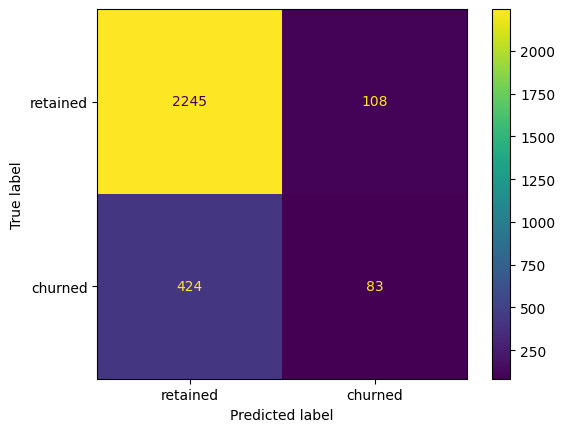

In [44]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

###  Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

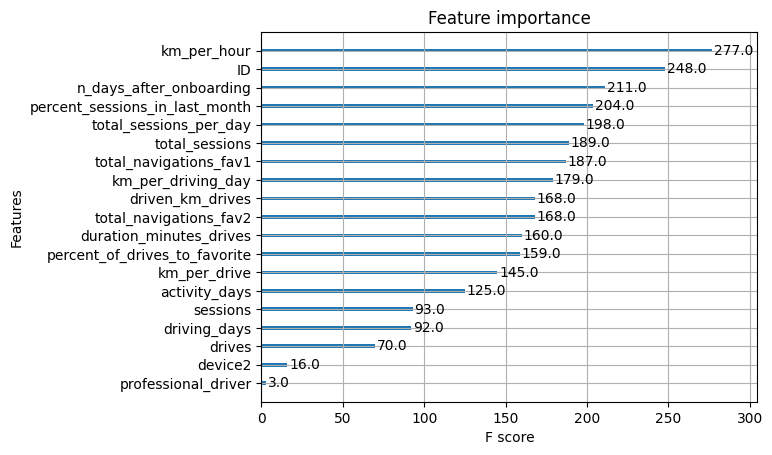

In [45]:
plot_importance(xgb_cv.best_estimator_)